In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

Get data, cleanning it, indexing with dates aggregating sentiment per day and saving it to another dataframe.

In [202]:
data = pd.read_csv('ProjectPH.csv', usecols = [i for i in range(1,7)], index_col=0, parse_dates= True)
data['created'] = pd.to_datetime(data.index)


## ['[effacé]', '[supprimé]', 'Title', 'title', 'Title.']
to_delete = np.array(data.selftext.value_counts().index[0:5])
posts_to_delete_filter = data.selftext.isin(to_delete)
print(f'#deleted: {np.sum(posts_to_delete_filter)]}, #rows:{data.shape[0]}, %deleted: {np.sum(posts_to_delete_filter)/data.shape[0]}')
data = data[~posts_to_delete_filter]

# date_time_format = '%Y-%m-%d %H:%M:%S'

## create df per day
dates = np.sort(np.unique(data.created.dt.date))
mean_per_day = data.groupby(data.index.date).mean()

data_per_day = pd.DataFrame({"day": dates, "polarity": mean_per_day.sentiment_polarity, "subjectivity": mean_per_day.sentiment_subjectivity})
data_per_day.index, data_per_day.day = pd.DatetimeIndex(data_per_day.index), pd.to_datetime(data_per_day.index)
data_per_day.head()

19380 51036 0.3797319539148836


Computing mean polarity per day per month, that could be used as prediction or trend for 2022.

In [300]:
month_day_vector = pd.to_datetime([f"2020-{str(month)}-{str(day)}" for day, month in zip(data.index.day, data.index.month)])
month_day_uniques = month_day_vector.unique().sort_values(ascending=1)

polarity_mean_per_day = []
subjectivity_mean_per_day = []
for month_day in month_day_uniques:
    filter_same_month_and_day = np.logical_and(data.index.day == month_day.day, data.index.month ==  month_day.month)
    polarity_mean_per_day.append(np.sum(data[filter_same_month_and_day].sentiment_polarity)/np.sum(filter_same_month_and_day))
    subjectivity_mean_per_day.append(np.sum(data[filter_same_month_and_day].sentiment_subjectivity)/np.sum(filter_same_month_and_day))

# sentiment_per_month = data.sentiment_polarity.groupby(data.index.month).mean()

In [308]:
data_per_day.head()

,day,polarity,subjectivity
2016-08-15,2016-08-15,-0.035417,0.116667
2016-08-16,2016-08-16,0.066855,0.168214
2016-08-17,2016-08-17,0.059619,0.191298
2016-08-18,2016-08-18,0.030986,0.300668
2016-08-19,2016-08-19,0.079680,0.318844


Plotsss

In [337]:
data_per_day.index.day_name

<bound method inherit_from_data.<locals>.method of DatetimeIndex(['2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24',
               ...
               '2021-08-06', '2021-08-07', '2021-08-08', '2021-08-09',
               '2021-08-10', '2021-08-11', '2021-08-12', '2021-08-13',
               '2021-08-14', '2021-08-15'],
              dtype='datetime64[ns]', length=1806, freq=None)>

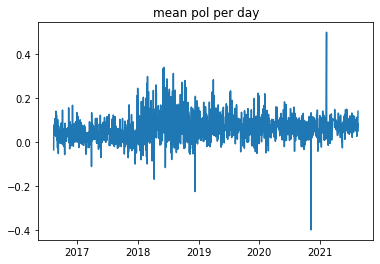

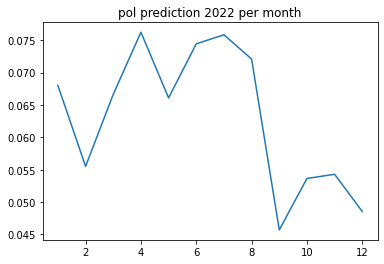

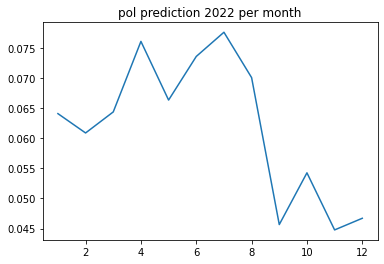

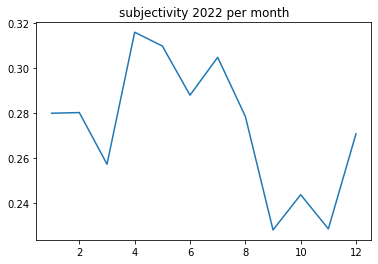

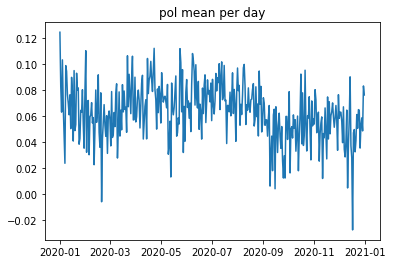

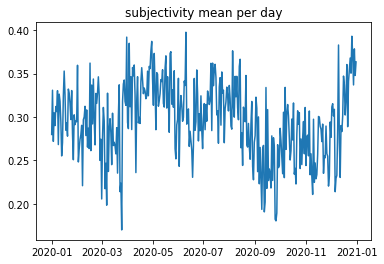

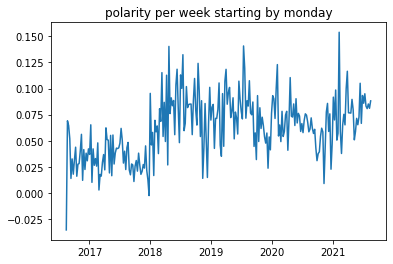

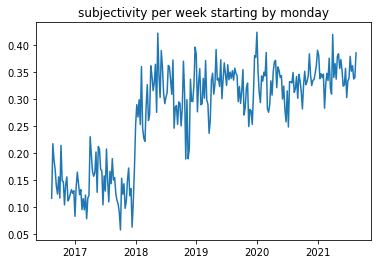

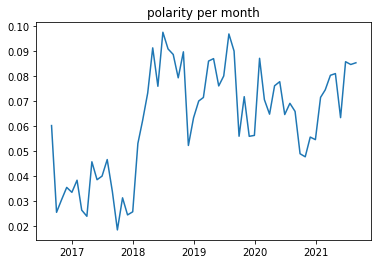

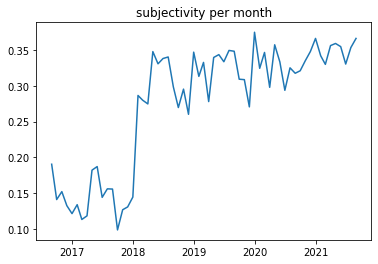

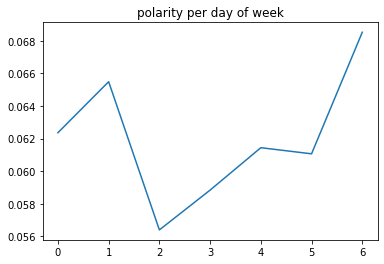

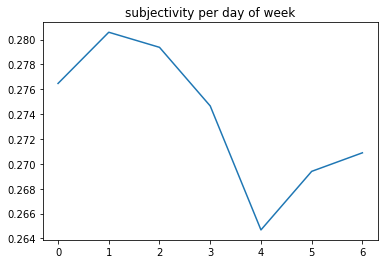

In [338]:
def plot(x, y, title):
    plt.plot(x, y)
    plt.title(title)
    plt.show()

def plot_df(df, title_to_add_after_col_name, y_col_names = [], x_col = "index"):
    y_col_names = df.columns if y_col_names == [] else y_col_names
    for col_name in y_col_names:
        x = df.index if x_col == "index" else df[x_col]
        plot(x, df[col_name], col_name + " " + title_to_add_after_col_name)

plot(data_per_day.index.date, data_per_day.polarity, "mean pol per day")

plot(months, sentiment_per_month, "pol prediction 2022 per month")
plot(months, data_per_day.groupby(data_per_day.index.month).polarity.mean(), "pol prediction 2022 per month")
plot(months, data_per_day.groupby(data_per_day.index.month).subjectivity.mean(), "subjectivity 2022 per month")

plot(month_day_uniques, polarity_mean_per_day, "pol mean per day")
plot(month_day_uniques, subjectivity_mean_per_day, "subjectivity mean per day")
plot_df(data_per_day.groupby(pd.Grouper(key = "day", freq="W-MON")).mean(), "per week starting by monday" )
plot_df(data_per_day.groupby(pd.Grouper(key = "day", freq="M")).mean(), "per month" )

plot_df(data_per_day.groupby(data_per_day.index.weekday).mean(), 'per day of week')

In [208]:
month_day_uniques

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=366, freq=None)